In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
plt.style.use(['seaborn-v0_8-white'])

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'.join(folders) +'/'+ fname)
get_figures_path = lambda fname: os.path.normpath('../local_data/figures/'+ fname)

In [3]:
file_proteomic_replicate_correlations = get_data_path(['upadhya_ryan_2022'], 'TableS2.xlsx')
file_collated_results_cptac_tm = get_local_data_path(['results'], 'Collated_TM_Results_CPTAC.parquet')

In [4]:
collated_results_tm = pd.read_parquet(file_collated_results_cptac_tm).reset_index().rename(columns={'index': 'Protein'})
collated_results_tm.replace('Pdac', 'PDAC', inplace=True)
collated_results_tm[:2]

,Protein,test_pearson,test_spearman,test_r2,test_rmse,test_nrmse,Study,FeatureSet
0,A2M,0.157005,0.156100,-0.123132,1.634801,0.268630,BrCa2020,Baseline
1,A2ML1,0.654152,0.550776,0.291372,2.708925,0.217844,BrCa2020,Baseline


In [5]:
collated_results_tm_subset = collated_results_tm[collated_results_tm['FeatureSet'] == 'VAE1000 + PI400'][['Protein', 
                                                                                                          'test_pearson', 
                                                                                                          'Study']]
collated_results_tm_subset[:2]

,Protein,test_pearson,Study
309631,A2M,0.534935,BrCa2020
309632,AAAS,0.447559,BrCa2020


In [6]:
aggregated_normalized_ranks = pd.read_excel(file_proteomic_replicate_correlations, 
                                sheet_name='B. Protein reproducibility rank', index_col=0)['Aggregated Reproducibility Rank']
aggregated_normalized_ranks = aggregated_normalized_ranks.dropna()
aggregated_normalized_ranks[:2]

A1BG    0.575671
A2M     0.501120
Name: Aggregated Reproducibility Rank, dtype: float64

In [7]:
def get_matched_index(x1, x2):
    common_proteins = x1.index[x1.index.isin(x2.index)]
    return x1.reindex(common_proteins), x2.reindex(common_proteins)

def get_collated_results(study):
    return(collated_results_tm_subset[collated_results_tm_subset['Study'] == study].set_index('Protein')['test_pearson'])

def dataframe_from_dict(factors, *dict_args, repeat_factor=1, interchange_factor_data=False):
    dataframe = pd.DataFrame.from_dict(dict_args[0], orient='index')
    for i in range(1, len(dict_args)-1):
        dataframe = dataframe.append(pd.DataFrame.from_dict(dict_args[i], orient='index'))
    dataframe.reset_index(inplace=True)
    dataframe.columns=['Data', 'R-squared']
    protein_count = factors.pop()
    dataframe['Factor'] = np.repeat(factors, repeat_factor)
    if(interchange_factor_data):
        dataframe.rename(columns={'Factor': 'Data', 'Data':'Factor'}, inplace=True)
        dataframe.Factor = dataframe.Factor.str.replace('Reproducibility', 'Protein\nReproducibility')
    #to print the dataframe 
    dataframe = dataframe.pivot(index='Data', columns='Factor', values='R-squared').reset_index()
    dataframe[protein_count] = dataframe['Data'].map(dict_args[-1])
    display( HTML( dataframe.to_html().replace("\\n","<br>") ) )
    #to plot the data along with the protein count used for the analysis 
    dataframe['Data'] = r'$\mathbf{' + dataframe['Data'] + '}$' +'\n' + '(N=' + dataframe[protein_count].astype(int).astype(str) + ')'
    dataframe['Data'].replace('$\mathbf{Transcriptomic Reproducibility}$\n(N=10036)',     
                              '$\mathbf{Transcriptomic}$\n$\mathbf{Reproducibility}$\n$\mathbf{(CCLE-Klijn)}$\n(N=10036)', inplace=True) 
    dataframe.drop(columns=protein_count, inplace=True)    
    dataframe = pd.melt(dataframe, id_vars='Data').rename(columns={'value':'R-squared'})
    dataframe["Factor"] = pd.Categorical(dataframe["Factor"], categories=factors) if(not interchange_factor_data) else \
                          pd.Categorical(dataframe["Factor"], categories=['Ovarian Protein\nReproducibility Rank', 
                                                                          'CCLE Protein\nReproducibility Rank', 
                                                                          'Colon Protein\nReproducibility Rank', 
                                                                          'Aggregated Protein\nReproducibility Rank'])
    dataframe.sort_values(by="Factor", inplace=True)
    return dataframe

import statsmodels.api as sm
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = get_matched_index(x.dropna(), y.dropna()) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset)).fit()
    return est

In [8]:
rsquared_predictions = {}
rsquared_predictions['PDAC'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=get_collated_results('PDAC')).rsquared_adj*100, 2)
rsquared_predictions['BrCa2020'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=get_collated_results('BrCa2020')).rsquared_adj*100, 2)
rsquared_predictions['LUAD'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=get_collated_results('LUAD')).rsquared_adj*100, 2)
rsquared_predictions['ccRCC'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=get_collated_results('ccRCC')).rsquared_adj*100, 2)
rsquared_predictions['HNSCC'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=get_collated_results('HNSCC')).rsquared_adj*100, 2)
rsquared_predictions['LSCC'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=get_collated_results('LSCC')).rsquared_adj*100, 2)

In [9]:
from dataclasses import dataclass, field
@dataclass
class additional_plot_parameters:   
    title: str = field(default=None)
    xlab: str = field(default=None)
    ylab: str = field(default=None)
    palette: list = field(default=None)
    xaxis_grid: bool = field(default=False)    
    yaxis_grid: bool = field(default=True)
    show_legend: bool = field(default=True)      
    anchor_legend_at: tuple = field(default=None)
    r2 : float = field(default=None)

def stratify_into_deciles(x, y, complex_subunits=[]):
    x_subset, y_subset = get_matched_index(x, y)
    dataframe = pd.DataFrame('', index=x_subset.index, columns=['maximum', 'deciles'])
    dataframe['maximum'] = pd.qcut(x_subset, 10).apply(lambda x: round(x.right, 2))
    dataframe['deciles'] = pd.qcut(x_subset, 10, labels = False) + 1
    dataframe = dataframe.sort_values(by='deciles')
    dataframe['Decile_Altered'] = dataframe['deciles'].astype(str) +  '\n('+  dataframe['maximum'].astype(str) + ')'
    dataframe = pd.concat([dataframe, x_subset, y_subset], axis=1)
    if(len(complex_subunits) > 0):
        dataframe['ComplexSubunit'] = [True if x in complex_subunits else False for x in dataframe.index] 
        dataframe = dataframe.groupby(by=['Decile_Altered','ComplexSubunit']).mean()       
        dataframe = dataframe.reset_index().sort_values('deciles').drop(columns='deciles')
    return dataframe

def draw_boxplot(ax, x, y, args, stratify=True):
    dataframe = stratify_into_deciles(x, y)  
    global_median = dataframe[y.name].median()
    ax.hlines(global_median, colors='#999999', linestyle=':', linewidth=1.5, xmin=-1, xmax =10, zorder=10)
    sns.boxplot(y=y.name, x='Decile_Altered', data=dataframe, showfliers=False, ax=ax,
               medianprops={'color':'black', 'linewidth':1.25, 'linestyle': '-'},
               whiskerprops={'color': args.palette[0], 'linewidth':1.5, 'linestyle': '--'}, 
               capprops={'linewidth': 0}, boxprops={'facecolor': args.palette[0], 'linewidth': 0})
  
    ax.set_title(args.title, weight='bold', y=1.05, size=14)
    ax.xaxis.labelpad = 10
    medians = dataframe.groupby(['deciles'])[y.name].median().round(2)
    for xtick in ax.get_xticks():  
        if(medians.iloc[xtick] > global_median):
            ax.text(xtick, medians.iloc[xtick] + 0.025, medians.iloc[xtick], horizontalalignment='center',size='9',color='black')
        else:
            ax.text(xtick, medians.iloc[xtick] - 0.075, medians.iloc[xtick], horizontalalignment='center',size='9',color='black')
#     count = len(dataframe)
#     ax.text(xtick, ax.get_ylim()[1] , 'N = '+ str(count), horizontalalignment='center',size='12', color='black')
    
    if(args.r2!=None):
        at = AnchoredText("$\mathregular{R^2}$ = "+ str(round(args.r2, 2))+"%", loc="lower right", frameon=True, 
                               prop=dict(fontsize='12', color='black'))
        at.patch.set_edgecolor('white')
        at.patch.set_facecolor('white')
        at.patch.set_alpha(1)
        
        ax.add_artist(at)
    ax.set_xlabel(args.xlab) 
    ax.set_ylabel(args.ylab)
    ax.xaxis.grid(args.xaxis_grid, linewidth=0.5) if args.xaxis_grid else ax.xaxis.grid(args.xaxis_grid)
    ax.yaxis.grid(args.yaxis_grid, linewidth=0.5) if args.yaxis_grid else ax.yaxis.grid(args.yaxis_grid)

In [10]:
palette = ['#E69F00']; xlab = "Aggregated Protein Reproducibility \nDeciles"; ylab='Prediction scores for\nVAE1000 + PI400'
args = [additional_plot_parameters(xlab=xlab, palette=palette, 
                                   ylab=ylab, r2=rsquared_predictions['PDAC'], title = 'PDAC'),
        additional_plot_parameters(xlab=xlab, palette=palette, 
                                   ylab=ylab, r2=rsquared_predictions['BrCa2020'],title='BrCa 2020'), 
        additional_plot_parameters(xlab=xlab, palette=palette, 
                                   ylab=ylab, r2=rsquared_predictions['LUAD'], title = 'LUAD'),
        additional_plot_parameters(xlab=xlab, palette=palette, 
                                   ylab=ylab, r2=rsquared_predictions['ccRCC'], title='ccRCC'),
        additional_plot_parameters(xlab=xlab, palette=palette, 
                                   ylab=ylab, r2=rsquared_predictions['HNSCC'], title = 'HNSCC'),
        additional_plot_parameters(xlab=xlab, palette=palette, 
                                   ylab=ylab, r2=rsquared_predictions['LSCC'], title='LSCC')]

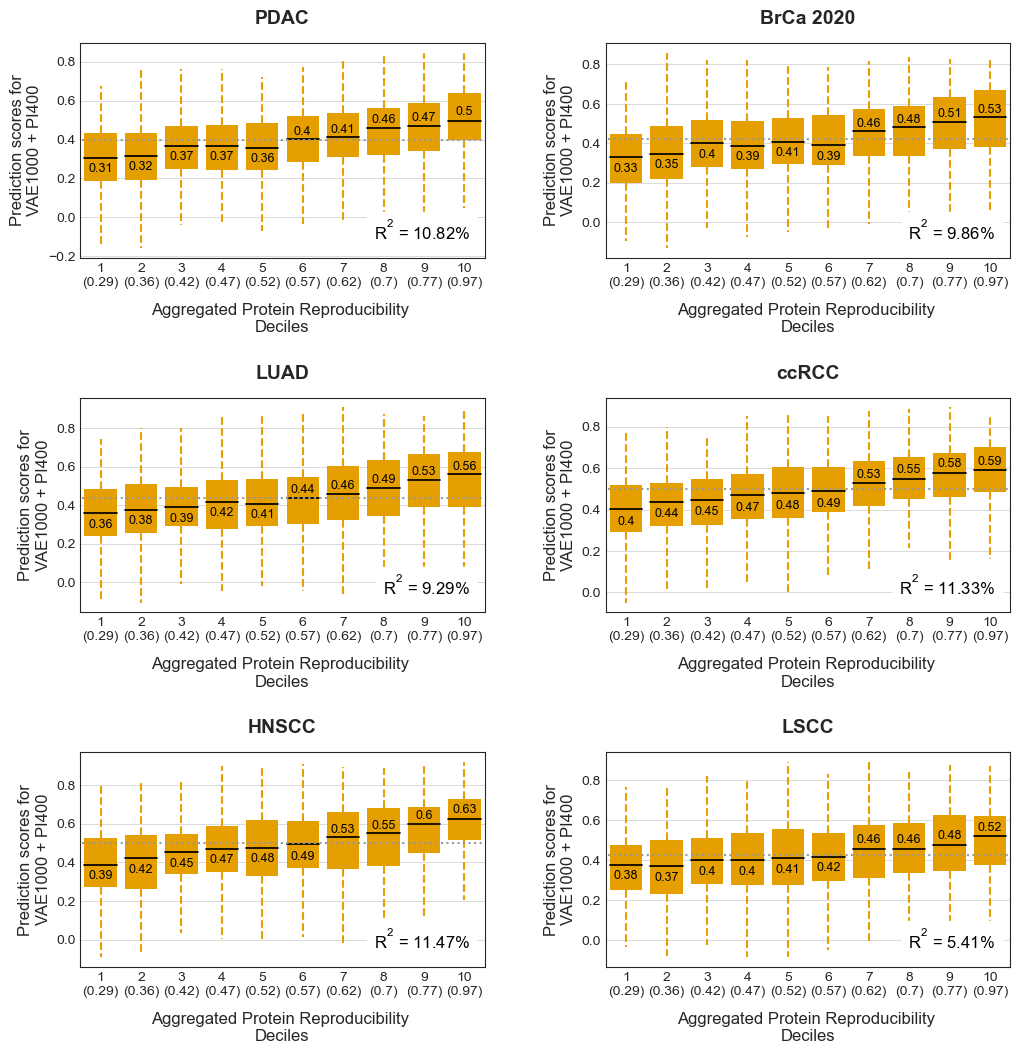

In [11]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12,}):
    figure, ax = plt.subplots(3, 2, figsize=(12, 12))
    draw_boxplot(ax[0,0], aggregated_normalized_ranks, get_collated_results('PDAC'), args[0])
    draw_boxplot(ax[0,1], aggregated_normalized_ranks, get_collated_results('BrCa2020'), args[1])
    draw_boxplot(ax[1,0], aggregated_normalized_ranks, get_collated_results('LUAD'), args[2])
    draw_boxplot(ax[1,1], aggregated_normalized_ranks, get_collated_results('ccRCC'), args[3])
    draw_boxplot(ax[2,0], aggregated_normalized_ranks, get_collated_results('HNSCC'), args[4])
    draw_boxplot(ax[2,1], aggregated_normalized_ranks, get_collated_results('LSCC'), args[5])
    plt.subplots_adjust(wspace=0.3, hspace=0.65)
    figure.savefig(get_figures_path('FigureS6.png'), bbox_inches='tight', dpi=300)